In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Mar  6 19:30:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 38%   50C    P0    35W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import All_CNN6Layer_A as ModelA
from model.models_mjp_19November20 import All_CNN6Layer_E as ModelE
from model.models_mjp_19November20 import All_CNN8Layer_W as ModelW
from model.models_mjp_26December20 import All_CNN10Layer_X as ModelX
from model.models_mjp_26December20 import All_CNN8Layer_Y as ModelY
from model.models_mjp_30Jan21_AllCNN import ACN_2_10L_4S_BN as ModelXX

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/awkward/__init__.py:23: DeprecationWarning: Consider switching from 'awkward' to 'awkward1', since the new interface will become the default later this year (2020).

    pip install -U awkward1

In Python:

    >>> import awkward1 as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  DeprecationWarning


Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 100, 1e-4, 220)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## This is used when training with the original KDE
'''
## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)
'''

## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 13.79 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 13.34 s
Constructing 160000 event dataset took 5.816 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 3.23 s
Constructing 20000 event dataset took 0.1735 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelXX()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path, freeze_weights=True)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/07cfa483f923494c94001fe45115c591/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=True)

we also froze 9 weights
Of the 32.5 parameter layers to update in the current model, 9.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ACN_2_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dr

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


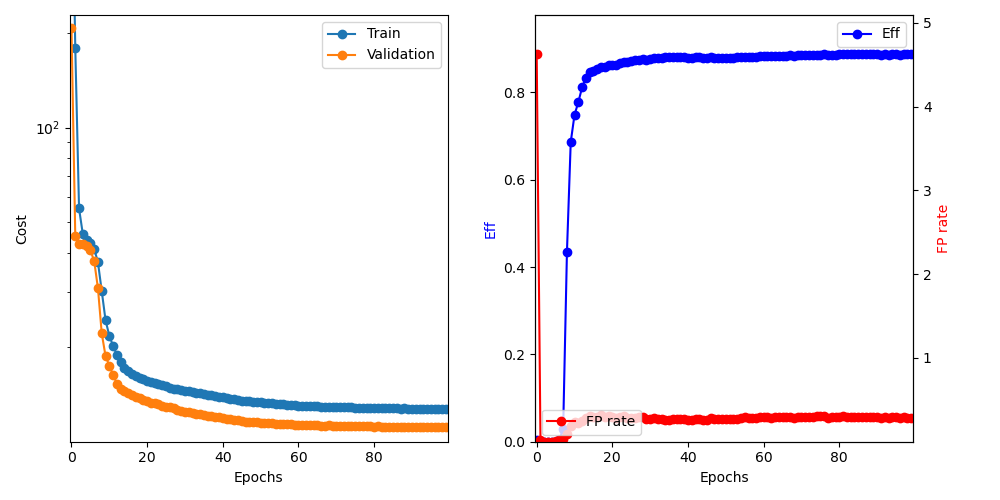

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  ACN_2_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6

/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 220: train=932.665, val=207.18, took 40.72 s
  Validation Found 511 of 108007, added 92586 (eff 0.47%) (4.63 FP/event)
Result epoch:  220
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 221: train=179.612, val=45.3211, took 40.249 s
  Validation Found 0 of 108007, added 395 (eff 0.00%) (0.0197 FP/event)
Result epoch:  221
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 222: train=55.3087, val=42.7908, took 40.221 s
  Validation Found 0 of 108007, added 8 (eff 0.00%) (0.0004 FP/event)
Result epoch:  222
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 223: train=45.8344, val=42.6514, took 40.184 s
  Validation Found 0 of 108007, added 2 (eff 0.00%) (0.0001 FP/event)
Result epoch:  223
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 224: train=43.9467, val=42.0377, took 40.199 s
  Validation Found 0 of 108007, added 10 (eff 0.00%) (0.0005 FP/event)
Result epoch:  224
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 225: train=42.8143, val=40.6881, took 40.192 s
  Validation Found 43 of 108007, added 64 (eff 0.04%) (0.0032 FP/event)
Result epoch:  225
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 226: train=41.1962, val=37.692, took 41.552 s
  Validation Found 380 of 108007, added 480 (eff 0.35%) (0.024 FP/event)
Result epoch:  226
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 227: train=37.2779, val=30.8114, took 40.217 s
  Validation Found 3233 of 108007, added 689 (eff 2.99%) (0.0344 FP/event)
Result epoch:  227
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 228: train=30.1999, val=22.1676, took 40.88 s
  Validation Found 46977 of 108007, added 1925 (eff 43.49%) (0.0962 FP/event)
Result epoch:  228
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 229: train=24.4419, val=18.7976, took 40.347 s
  Validation Found 74100 of 108007, added 3712 (eff 68.61%) (0.186 FP/event)
Result epoch:  229
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 230: train=21.7788, val=17.5121, took 40.461 s
  Validation Found 80823 of 108007, added 4651 (eff 74.83%) (0.233 FP/event)
Result epoch:  230
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 231: train=20.2353, val=16.3654, took 40.354 s
  Validation Found 83940 of 108007, added 4353 (eff 77.72%) (0.218 FP/event)
Result epoch:  231
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 232: train=18.9433, val=15.3486, took 40.366 s
  Validation Found 87611 of 108007, added 5041 (eff 81.12%) (0.252 FP/event)
Result epoch:  232
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 233: train=17.9332, val=14.7805, took 40.361 s
  Validation Found 90040 of 108007, added 5667 (eff 83.36%) (0.283 FP/event)
Result epoch:  233
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 234: train=17.2477, val=14.5354, took 40.367 s
  Validation Found 91427 of 108007, added 6194 (eff 84.65%) (0.31 FP/event)
Result epoch:  234
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 235: train=16.8241, val=14.3213, took 40.364 s
  Validation Found 91705 of 108007, added 5930 (eff 84.91%) (0.296 FP/event)
Result epoch:  235
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 236: train=16.521, val=14.1071, took 40.342 s
  Validation Found 92146 of 108007, added 5988 (eff 85.31%) (0.299 FP/event)
Result epoch:  236
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 237: train=16.2539, val=13.9626, took 40.355 s
  Validation Found 92619 of 108007, added 6289 (eff 85.75%) (0.314 FP/event)
Result epoch:  237
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 238: train=16.0372, val=13.8038, took 40.358 s
  Validation Found 92713 of 108007, added 5961 (eff 85.84%) (0.298 FP/event)
Result epoch:  238
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 239: train=15.8538, val=13.6575, took 40.347 s
  Validation Found 93038 of 108007, added 6102 (eff 86.14%) (0.305 FP/event)
Result epoch:  239
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 240: train=15.7061, val=13.5439, took 40.349 s
  Validation Found 93122 of 108007, added 5785 (eff 86.22%) (0.289 FP/event)
Result epoch:  240
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 241: train=15.562, val=13.3638, took 40.355 s
  Validation Found 93271 of 108007, added 5703 (eff 86.36%) (0.285 FP/event)
Result epoch:  241
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 242: train=15.428, val=13.2862, took 40.347 s
  Validation Found 93641 of 108007, added 5864 (eff 86.70%) (0.293 FP/event)
Result epoch:  242
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 243: train=15.3, val=13.2445, took 40.341 s
  Validation Found 93951 of 108007, added 6208 (eff 86.99%) (0.31 FP/event)
Result epoch:  243
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 244: train=15.1644, val=13.0603, took 40.343 s
  Validation Found 93873 of 108007, added 5726 (eff 86.91%) (0.286 FP/event)
Result epoch:  244
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 245: train=15.0372, val=12.976, took 41.678 s
  Validation Found 94051 of 108007, added 5563 (eff 87.08%) (0.278 FP/event)
Result epoch:  245
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 246: train=14.9115, val=12.8989, took 40.372 s
  Validation Found 94309 of 108007, added 5694 (eff 87.32%) (0.285 FP/event)
Result epoch:  246
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 247: train=14.8073, val=12.8149, took 40.365 s
  Validation Found 94471 of 108007, added 5787 (eff 87.47%) (0.289 FP/event)
Result epoch:  247
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 248: train=14.7352, val=12.6817, took 40.346 s
  Validation Found 94529 of 108007, added 5808 (eff 87.52%) (0.29 FP/event)
Result epoch:  248
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 249: train=14.6548, val=12.5681, took 40.419 s
  Validation Found 94458 of 108007, added 5456 (eff 87.46%) (0.273 FP/event)
Result epoch:  249
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 250: train=14.5897, val=12.502, took 40.826 s
  Validation Found 94604 of 108007, added 5394 (eff 87.59%) (0.27 FP/event)
Result epoch:  250
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 251: train=14.5205, val=12.4344, took 40.349 s
  Validation Found 94893 of 108007, added 5648 (eff 87.86%) (0.282 FP/event)
Result epoch:  251
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 252: train=14.451, val=12.3849, took 40.349 s
  Validation Found 94935 of 108007, added 5432 (eff 87.90%) (0.272 FP/event)
Result epoch:  252
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 253: train=14.375, val=12.295, took 40.327 s
  Validation Found 94933 of 108007, added 5363 (eff 87.90%) (0.268 FP/event)
Result epoch:  253
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 254: train=14.3195, val=12.261, took 41.667 s
  Validation Found 95035 of 108007, added 5227 (eff 87.99%) (0.261 FP/event)
Result epoch:  254
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 255: train=14.2423, val=12.1978, took 40.345 s
  Validation Found 95100 of 108007, added 5281 (eff 88.05%) (0.264 FP/event)
Result epoch:  255
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 256: train=14.1728, val=12.1488, took 40.249 s
  Validation Found 95188 of 108007, added 5395 (eff 88.13%) (0.27 FP/event)
Result epoch:  256
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 257: train=14.1164, val=12.12, took 41.018 s
  Validation Found 95121 of 108007, added 5362 (eff 88.07%) (0.268 FP/event)
Result epoch:  257
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 258: train=14.0258, val=12.039, took 40.264 s
  Validation Found 95150 of 108007, added 5387 (eff 88.10%) (0.269 FP/event)
Result epoch:  258
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 259: train=13.9447, val=11.9846, took 40.284 s
  Validation Found 95106 of 108007, added 5453 (eff 88.06%) (0.273 FP/event)
Result epoch:  259
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 260: train=13.8741, val=11.9136, took 40.28 s
  Validation Found 94907 of 108007, added 5249 (eff 87.87%) (0.262 FP/event)
Result epoch:  260
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 261: train=13.7982, val=11.8794, took 40.267 s
  Validation Found 94960 of 108007, added 5247 (eff 87.92%) (0.262 FP/event)
Result epoch:  261
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 262: train=13.7237, val=11.8281, took 40.274 s
  Validation Found 95094 of 108007, added 5467 (eff 88.04%) (0.273 FP/event)
Result epoch:  262
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 263: train=13.6742, val=11.7732, took 40.309 s
  Validation Found 95027 of 108007, added 5394 (eff 87.98%) (0.27 FP/event)
Result epoch:  263
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 264: train=13.6211, val=11.7524, took 40.291 s
  Validation Found 94931 of 108007, added 5211 (eff 87.89%) (0.261 FP/event)
Result epoch:  264
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 265: train=13.5606, val=11.6871, took 40.293 s
  Validation Found 94895 of 108007, added 5289 (eff 87.86%) (0.264 FP/event)
Result epoch:  265
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 266: train=13.5167, val=11.6304, took 40.294 s
  Validation Found 95082 of 108007, added 5645 (eff 88.03%) (0.282 FP/event)
Result epoch:  266
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 267: train=13.4775, val=11.6059, took 39.254 s
  Validation Found 94873 of 108007, added 5333 (eff 87.84%) (0.267 FP/event)
Result epoch:  267
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 268: train=13.4386, val=11.5801, took 39.083 s
  Validation Found 94933 of 108007, added 5379 (eff 87.90%) (0.269 FP/event)
Result epoch:  268
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 269: train=13.4023, val=11.5663, took 38.93 s
  Validation Found 94972 of 108007, added 5536 (eff 87.93%) (0.277 FP/event)
Result epoch:  269
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 270: train=13.3766, val=11.5334, took 38.868 s
  Validation Found 94948 of 108007, added 5518 (eff 87.91%) (0.276 FP/event)
Result epoch:  270
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 271: train=13.3378, val=11.5219, took 38.932 s
  Validation Found 94915 of 108007, added 5394 (eff 87.88%) (0.27 FP/event)
Result epoch:  271
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 272: train=13.2974, val=11.4885, took 38.853 s
  Validation Found 94972 of 108007, added 5534 (eff 87.93%) (0.277 FP/event)
Result epoch:  272
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 273: train=13.2752, val=11.4833, took 38.881 s
  Validation Found 95007 of 108007, added 5515 (eff 87.96%) (0.276 FP/event)
Result epoch:  273
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 274: train=13.2556, val=11.4533, took 38.863 s
  Validation Found 95051 of 108007, added 5713 (eff 88.00%) (0.286 FP/event)
Result epoch:  274
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 275: train=13.2165, val=11.4608, took 38.872 s
  Validation Found 95223 of 108007, added 5842 (eff 88.16%) (0.292 FP/event)
Result epoch:  275
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 276: train=13.1925, val=11.4424, took 38.879 s
  Validation Found 95161 of 108007, added 5740 (eff 88.11%) (0.287 FP/event)
Result epoch:  276
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 277: train=13.1705, val=11.4232, took 41.258 s
  Validation Found 95221 of 108007, added 5781 (eff 88.16%) (0.289 FP/event)
Result epoch:  277
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 278: train=13.1207, val=11.4136, took 40.365 s
  Validation Found 95129 of 108007, added 5607 (eff 88.08%) (0.28 FP/event)
Result epoch:  278
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 279: train=13.087, val=11.3671, took 40.355 s
  Validation Found 95349 of 108007, added 5933 (eff 88.28%) (0.297 FP/event)
Result epoch:  279
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 280: train=13.0765, val=11.3541, took 40.403 s
  Validation Found 95343 of 108007, added 5831 (eff 88.27%) (0.292 FP/event)
Result epoch:  280
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 281: train=13.0595, val=11.3368, took 40.381 s
  Validation Found 95335 of 108007, added 5908 (eff 88.27%) (0.295 FP/event)
Result epoch:  281
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 282: train=13.0333, val=11.3346, took 40.391 s
  Validation Found 95301 of 108007, added 5760 (eff 88.24%) (0.288 FP/event)
Result epoch:  282
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 283: train=13.0213, val=11.3293, took 40.371 s
  Validation Found 95470 of 108007, added 5949 (eff 88.39%) (0.297 FP/event)
Result epoch:  283
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 284: train=13.0059, val=11.3133, took 40.375 s
  Validation Found 95484 of 108007, added 5937 (eff 88.41%) (0.297 FP/event)
Result epoch:  284
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 285: train=12.9891, val=11.3048, took 40.351 s
  Validation Found 95448 of 108007, added 5860 (eff 88.37%) (0.293 FP/event)
Result epoch:  285
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 286: train=12.9762, val=11.2922, took 40.343 s
  Validation Found 95457 of 108007, added 5937 (eff 88.38%) (0.297 FP/event)
Result epoch:  286
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 287: train=12.961, val=11.2943, took 40.385 s
  Validation Found 95549 of 108007, added 5995 (eff 88.47%) (0.3 FP/event)
Result epoch:  287
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 288: train=12.9503, val=11.3129, took 40.351 s
  Validation Found 95485 of 108007, added 5772 (eff 88.41%) (0.289 FP/event)
Result epoch:  288
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 289: train=12.933, val=11.2825, took 40.526 s
  Validation Found 95553 of 108007, added 5863 (eff 88.47%) (0.293 FP/event)
Result epoch:  289
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 290: train=12.9315, val=11.2632, took 40.442 s
  Validation Found 95537 of 108007, added 5864 (eff 88.45%) (0.293 FP/event)
Result epoch:  290
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 291: train=12.9219, val=11.2663, took 40.388 s
  Validation Found 95552 of 108007, added 5923 (eff 88.47%) (0.296 FP/event)
Result epoch:  291
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 292: train=12.9048, val=11.2683, took 40.395 s
  Validation Found 95597 of 108007, added 5905 (eff 88.51%) (0.295 FP/event)
Result epoch:  292
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 293: train=12.8943, val=11.2745, took 40.407 s
  Validation Found 95562 of 108007, added 5800 (eff 88.48%) (0.29 FP/event)
Result epoch:  293
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 294: train=12.9083, val=11.2485, took 40.401 s
  Validation Found 95724 of 108007, added 6113 (eff 88.63%) (0.306 FP/event)
Result epoch:  294
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 295: train=12.8864, val=11.2431, took 40.38 s
  Validation Found 95742 of 108007, added 6085 (eff 88.64%) (0.304 FP/event)
Result epoch:  295
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 296: train=12.8708, val=11.2347, took 40.411 s
  Validation Found 95751 of 108007, added 6065 (eff 88.65%) (0.303 FP/event)
Result epoch:  296
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 297: train=12.8819, val=11.2343, took 40.385 s
  Validation Found 95596 of 108007, added 5781 (eff 88.51%) (0.289 FP/event)
Result epoch:  297
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 298: train=12.8709, val=11.2324, took 40.388 s
  Validation Found 95671 of 108007, added 5869 (eff 88.58%) (0.293 FP/event)
Result epoch:  298
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 299: train=12.8446, val=11.2178, took 40.38 s
  Validation Found 95722 of 108007, added 5890 (eff 88.63%) (0.294 FP/event)
Result epoch:  299
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 300: train=12.8383, val=11.2085, took 40.368 s
  Validation Found 95776 of 108007, added 5936 (eff 88.68%) (0.297 FP/event)
Result epoch:  300
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 301: train=12.8378, val=11.2182, took 40.406 s
  Validation Found 95885 of 108007, added 6054 (eff 88.78%) (0.303 FP/event)
Result epoch:  301
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 302: train=12.8265, val=11.1962, took 40.396 s
  Validation Found 95811 of 108007, added 5969 (eff 88.71%) (0.298 FP/event)
Result epoch:  302
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 303: train=12.8133, val=11.1884, took 40.894 s
  Validation Found 95824 of 108007, added 5937 (eff 88.72%) (0.297 FP/event)
Result epoch:  303
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 304: train=12.7989, val=11.1965, took 40.277 s
  Validation Found 95838 of 108007, added 5916 (eff 88.73%) (0.296 FP/event)
Result epoch:  304
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 305: train=12.8073, val=11.1905, took 40.261 s
  Validation Found 95777 of 108007, added 5866 (eff 88.68%) (0.293 FP/event)
Result epoch:  305
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 306: train=12.805, val=11.1797, took 40.25 s
  Validation Found 95783 of 108007, added 5886 (eff 88.68%) (0.294 FP/event)
Result epoch:  306
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 307: train=12.7899, val=11.1768, took 40.255 s
  Validation Found 95772 of 108007, added 5863 (eff 88.67%) (0.293 FP/event)
Result epoch:  307
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 308: train=12.7968, val=11.1844, took 40.841 s
  Validation Found 95767 of 108007, added 5811 (eff 88.67%) (0.291 FP/event)
Result epoch:  308
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 309: train=12.7878, val=11.1728, took 40.274 s
  Validation Found 95923 of 108007, added 5955 (eff 88.81%) (0.298 FP/event)
Result epoch:  309
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 310: train=12.7854, val=11.1632, took 40.27 s
  Validation Found 95796 of 108007, added 5833 (eff 88.69%) (0.292 FP/event)
Result epoch:  310
Average Eff:  0.8869425129852695
Average FP Rate:  0.29163541822908856


Epoch 311: train=12.7723, val=11.1838, took 40.274 s
  Validation Found 95748 of 108007, added 5710 (eff 88.65%) (0.285 FP/event)
Result epoch:  311
Average Eff:  1.773440610330812
Average FP Rate:  0.5771211439428029


Epoch 312: train=12.7723, val=11.1607, took 40.248 s
  Validation Found 95860 of 108007, added 6001 (eff 88.75%) (0.3 FP/event)
Result epoch:  312
Average Eff:  2.6609756775023845
Average FP Rate:  0.8771561421928904


Epoch 313: train=12.7668, val=11.179, took 40.265 s
  Validation Found 95739 of 108007, added 5731 (eff 88.64%) (0.287 FP/event)
Result epoch:  313
Average Eff:  3.547390446915478
Average FP Rate:  1.1636918154092295


Epoch 314: train=12.7739, val=11.1541, took 40.276 s
  Validation Found 95854 of 108007, added 5941 (eff 88.75%) (0.297 FP/event)
Result epoch:  314
Average Eff:  4.434869962132084
Average FP Rate:  1.4607269636518174


Epoch 315: train=12.7584, val=11.1493, took 40.238 s
  Validation Found 95828 of 108007, added 5912 (eff 88.72%) (0.296 FP/event)
Result epoch:  315
Average Eff:  5.3221087522105055
Average FP Rate:  1.7563121843907805


Epoch 316: train=12.7431, val=11.1542, took 40.285 s
  Validation Found 95727 of 108007, added 5662 (eff 88.63%) (0.283 FP/event)
Result epoch:  316
Average Eff:  6.208412417713667
Average FP Rate:  2.039398030098495


Epoch 317: train=12.7502, val=11.1603, took 40.264 s
  Validation Found 95845 of 108007, added 5830 (eff 88.74%) (0.291 FP/event)
Result epoch:  317
Average Eff:  7.095808604997825
Average FP Rate:  2.3308834558272085


Epoch 318: train=12.7593, val=11.1657, took 40.228 s
  Validation Found 95761 of 108007, added 5659 (eff 88.66%) (0.283 FP/event)
Result epoch:  318
Average Eff:  7.982427064912461
Average FP Rate:  2.613819309034548


Epoch 319: train=12.7466, val=11.153, took 40.293 s
  Validation Found 95799 of 108007, added 5737 (eff 88.70%) (0.287 FP/event)
Result epoch:  319
Averaging...

Average Eff:  0.8869397353875212
Average FP Rate:  0.29006549672516374



<IPython.core.display.Javascript object>


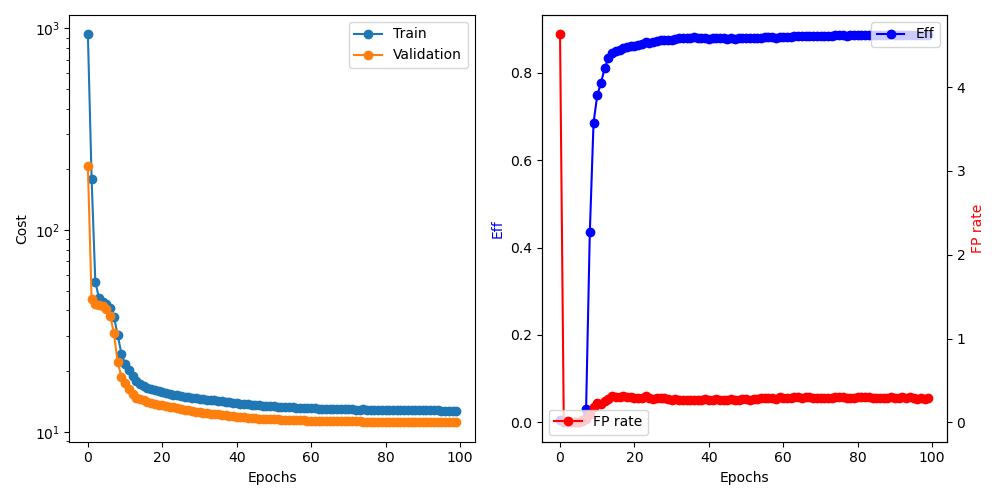

In [12]:
avgEff = 0.0
avgFP = 0.0
print('for model: ', model)   
run_name = 'ACN_1_10L_4S (P3)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate)) 
            
        # Redraw the figure
        fig.canvas.draw()  
        
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        # computes averages for eff and fp of last 10 epochs
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')
        mlflow.set_tag('KDE', 'Poca')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    fig.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
